## Import Modules

In [2]:
# import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
BASE_DIR = './Images/'
WORKING_DIR = './'

## Extract Image Features

In [8]:
# load vgg16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# Extract features from images
features = {}
directory = os.path.join(BASE_DIR)

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

100%|██████████| 8091/8091 [2:10:06<00:00,  1.04it/s]     


In [11]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [12]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [13]:
with open(os.path.join('./captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [14]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

100%|██████████| 40456/40456 [00:00<00:00, 346644.91it/s]


In [15]:
len(mapping)

8091

## Preprocess Text Data

In [16]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + " endseq"
            captions[i] = caption

In [17]:
# before preprocess of text
mapping['1105959054_9c3a738096']

['A child painting a picture .',
 'An artist paints clouds onto a canvas .',
 'A young girl painting a picture .',
 'A young girl with braids is painting with water colors on a white paper on the wall .',
 'The child paints on a large paper with water colors .']

In [18]:
# preprocess the text
clean(mapping)

In [19]:
# after preprocess of text
mapping['1105959054_9c3a738096']

['startseq child painting picture endseq',
 'startseq an artist paints clouds onto canvas endseq',
 'startseq young girl painting picture endseq',
 'startseq young girl with braids is painting with water colors on white paper on the wall endseq',
 'startseq the child paints on large paper with water colors endseq']

In [20]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [21]:
len(all_captions)

40455

In [22]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [23]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [24]:
vocab_size

8485

In [25]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [26]:
image_ids = list(mapping.keys())
train_val, test = train_test_split(image_ids, test_size=0.10, random_state=42)
train, val = train_test_split(train_val, test_size=0.056, random_state=42) 
print("Training set length:", len(train))
print("Validation set length:", len(val))
print("Testing set length:", len(test))

Training set length: 6873
Validation set length: 408
Testing set length: 810


In [27]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            if key not in mapping:
             print("Key not found in mapping:", key)
             continue
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [28]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
#Train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size
validation_steps = len(val) // batch_size

history = model.fit( 
    data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    epochs=epochs,
    steps_per_epoch=steps,
    validation_data=data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    validation_steps=validation_steps,
    verbose=1,
)

Epoch 1/30
214/214 [==============================] - 618s 3s/step - loss: 4.8883 - val_loss: 4.2578
Epoch 2/30
214/214 [==============================] - 696s 3s/step - loss: 3.8939 - val_loss: 3.9479
Epoch 3/30
214/214 [==============================] - 701s 3s/step - loss: 3.5060 - val_loss: 3.8748
Epoch 4/30
214/214 [==============================] - 646s 3s/step - loss: 3.2507 - val_loss: 3.8206
Epoch 5/30
214/214 [==============================] - 696s 3s/step - loss: 3.0623 - val_loss: 3.8265
Epoch 6/30
214/214 [==============================] - 675s 3s/step - loss: 2.9204 - val_loss: 3.8788
Epoch 7/30
214/214 [==============================] - 680s 3s/step - loss: 2.8135 - val_loss: 3.9707
Epoch 8/30
214/214 [==============================] - 679s 3s/step - loss: 2.7239 - val_loss: 3.9490
Epoch 9/30
214/214 [==============================] - 673s 3s/step - loss: 2.6419 - val_loss: 3.9803
Epoch 10/30
214/214 [==============================] - 662s 3s/step - loss: 2.5708 - val_lo

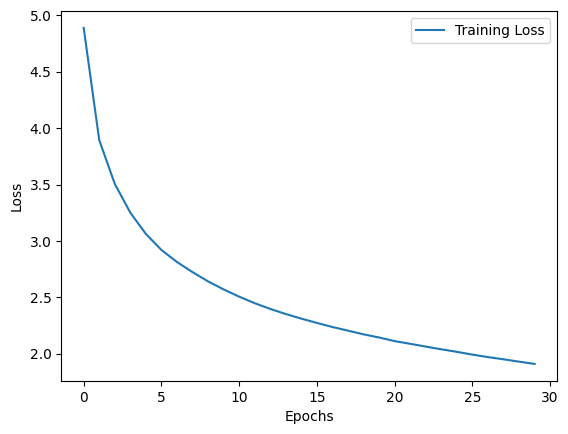

In [31]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
# Save the model
model.save(os.path.join(WORKING_DIR, 'image_captioning_model.h5'))

NameError: name 'model' is not defined

## Generate Captions for the Image

In [33]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu
actual_captions = []
predicted_captions = []

for key in tqdm(test):
    actual = mapping[key]
    predicted = predict_caption(model, features[key], tokenizer, max_length)
    actual = [caption.split() for caption in actual]
    predicted = predicted.split()
    actual_captions.append(actual)
    predicted_captions.append(predicted)

bleu1 = corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0))

print("BLEU-1 Score:", bleu1)
print("BLEU-2 Score:", bleu2)    

100%|██████████| 810/810 [10:01<00:00,  1.35it/s]


BLEU-1 Score: 0.5410638771422213
BLEU-2 Score: 0.31684482565619004


In [37]:
from PIL import Image
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq girl is stretched out in shallow water endseq
startseq girl wearing red and multi-colored bikini is laying on her back in shallow water endseq
startseq little girl in red swimsuit is laying on her back in shallow water endseq
startseq "a young girl is lying in the sand while ocean water is surrounding her ." endseq
startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq
--------------------Predicted--------------------
startseq little girl in green bathing suit is laying in the pool endseq


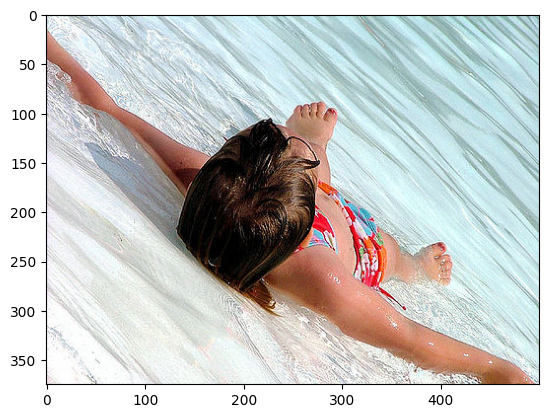

In [38]:
generate_caption("667626_18933d713e.jpg")

---------------------Actual---------------------
startseq couple stands close at the water 's edge endseq
startseq the two people stand by body of water and in front of bushes in fall endseq
startseq two people hold each other near pond endseq
startseq two people stand by the water endseq
startseq two people stand together on the edge of the water on the grass endseq
--------------------Predicted--------------------
startseq four people in canoe down the water endseq


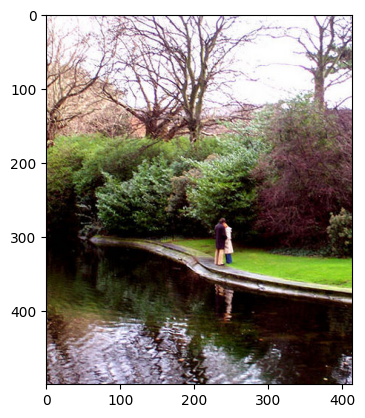

In [39]:
generate_caption("3637013_c675de7705.jpg")

## Test with Real Image

In [4]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [5]:
image_path = './Images/42637987_866635edf6.jpg'
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)
predict_caption(model, feature, tokenizer, max_length)

NameError: name 'predict_caption' is not defined

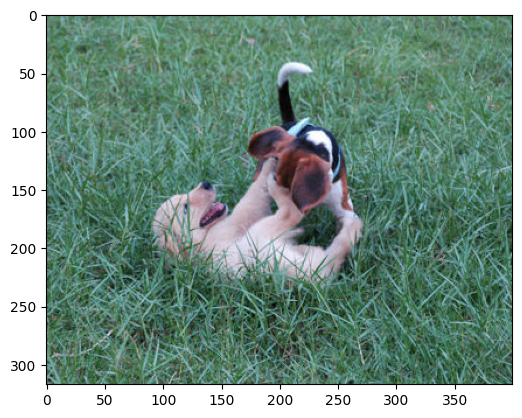

In [36]:
IMAGE = Image.open(image_path)
plt.imshow(IMAGE)